# Analysis and Visualization of Sinopia Graphs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext lab_black

import json

import rdflib
import requests
import kglab
import helpers
import widgets

## PCC BIBFRAME Work-Instance-Item Graph
We can use [Sinopia API](https://github.com/ld4p/sinopia_api) to construct a small RDF graph made up of a [BIBFRAME](https://bibframe.org/) Work, Instance, and Item and then create a knowledge graph for analysis and visualization of the entities along with their properties.

### Step One: Collect Sinopia URLs
First we will download the following resources from Sinopia's stage environment and then parse the RDF
contained in the resulting JSON.

- **BIBFRAME Work**: https://api.stage.sinopia.io/resource/bd3dad0c-484c-4426-a521-886bbc931fe1
- **BIBFRAME Instance**: https://api.stage.sinopia.io/resource/49f0c640-783a-4c14-9371-c39a2a2c8471
- **BIBFRAME Item**: https://api.stage.sinopia.io/resource/9e264bea-bf51-47a9-8c66-34a7488bf18a

In [2]:
sinopia_stage_urls = [
    "https://api.stage.sinopia.io/resource/bd3dad0c-484c-4426-a521-886bbc931fe1",
    "https://api.stage.sinopia.io/resource/49f0c640-783a-4c14-9371-c39a2a2c8471",
    "https://api.stage.sinopia.io/resource/9e264bea-bf51-47a9-8c66-34a7488bf18a",
]

### Step Two: Create RDF Namespaces and Graph

Here we create two namespaces for the BIBFRAME and Sinopia vocabularies and bind them to the new Sinopia graph.

In [3]:
BIBFRAME = rdflib.Namespace("http://id.loc.gov/ontologies/bibframe/")
SINOPIA = rdflib.Namespace("http://sinopia.io/vocabulary/")

sinopia_pcc_graph = rdflib.Graph()
sinopia_pcc_graph.namespace_manager.bind("bf", BIBFRAME)
sinopia_pcc_graph.namespace_manager.bind("sinopia", SINOPIA)

### Step Three: Download and Parse RDF into the Graph

We now loop through all of the URLs in the list of Sinopia URLs, query the Sinopoia Stage API endpoint for these resources, and add the JSON-LD to the graph.

In [4]:
print(f"Starting triples in our RDF graph {len(sinopia_pcc_graph)}")
for sinopia_url in sinopia_stage_urls:
    api_result = requests.get(sinopia_url)
    if api_result.status_code < 300:
        resource_json = api_result.json()
        # Need to serialize the JSON to a string for parsing
        sinopia_pcc_graph.parse(
            data=json.dumps(resource_json["data"]), format="json-ld"
        )
    else:
        print(
            f"ERROR {api_result.status_code} for {sinopia_url}\nDetail {api_result.text}"
        )
print(f"Finished ingesting resources, size of graph {len(sinopia_pcc_graph)}")

Starting triples in our RDF graph 0
Finished ingesting resources, size of graph 156


### Step Four: Create a Knowledge Graph

Now that we have our BIBFRAME Work, Instance, and Items parsed into our RDF graph, we will then create a knowledge graph.

In [5]:
sinopia_bf_kg = kglab.KnowledgeGraph(
    name="Sinopia Stage PCC Knowledge Graph", import_graph=sinopia_pcc_graph
)

### Step Five: Basic Graph Analysis

Our simple PCC BIBFRAME Knowledge Graph provides a number of methods that allow use to analyze the shape and structure RDF through a "graph" lens. 

In graph terminology, a **Node** is the fundemental unit and is represented in RDF by a URI or blank-node in the *subject* role or a URI, blank-node, or Literal in the *object* role. An **Edge** is a linkage between two nodes, in RDF terms, the *predicate* connecting the *subject* with the *object*. Because the order in triple matters, RDF is know as a directed graph. 



In [6]:
measure = kglab.Measure()
measure.measure_graph(sinopia_bf_kg)
print("Edges: {:,}\n".format(measure.get_edge_count()))
print("Nodes: {:,}\n".format(measure.get_node_count()))

Edges: 156

Nodes: 78



We can confirm that the number of edges in our PCC BIBFRAME graph is equal to the number of predicates by creating a list of all of the predicates and then calculate the number of members in that list using the builtin Python `len` function.

In [7]:
predicates = [p for p in sinopia_pcc_graph.predicates()]
print(
    f"""Total number of predicates: {len(predicates)}, 
         Test for equality: {len(predicates) == measure.get_edge_count()}"""
)

Total number of predicates: 156, 
         Test for equality: True


## Exercise 1: Create a Sinopia BIBFRAME Knowledge Graph
Using any of the three Sinopia environments (development, stage, or production), find a BIBFRAME Work with a corresponding BIBFRAME Instance and then replicate the steps above to create a Sinopia BIBFRAME Knowledge Graph.

# Visualization of the PCC BIBFRAME Graph

In [8]:
sinopia_pcc_subgraph = kglab.SubgraphTensor(sinopia_bf_kg)
pyvis_graph = sinopia_pcc_subgraph.build_pyvis_graph(notebook=True)
pyvis_graph.force_atlas_2based()
pyvis_graph.show("pcc_bf.fig01.html")

<hr>

# Sinopia Stage Graph Analysis and Visualizations
First we will load the saved knowledge graph and then will do similar analysis to the 

In [9]:
stage_kg = kglab.KnowledgeGraph()
stage_kg.load_jsonld("data/stage.json")
print(f"Total triples {len(stage_kg.rdf_graph()):,}")

Total triples 131,414


First let see how many edges and nodes are in all of the resources in Sinopia stage:

In [10]:
stage_measure = kglab.Measure()
stage_measure.measure_graph(stage_kg)

In [11]:
print("Edges: {:,}\n".format(stage_measure.get_edge_count()))
print("Nodes: {:,}\n".format(stage_measure.get_node_count()))

Edges: 131,414

Nodes: 38,961



## Visualization using Pandas DataFrames

With our stage knowledge graph, we can query our graph with SPARQL and return the results as a Panda's DataFrame. DataFrames offer a number of built-in graphs that can be useful for summarizing or visualizing information about the RDF.


In [12]:
classes_df = stage_kg.query_as_df(
    """
SELECT ?class
WHERE {
  ?url rdf:type ?class .
}
"""
)

In [13]:
classes_df["class"].value_counts()[0:35]

sinopia:PropertyTemplate                                           3969
bf:AdminMetadata                                                   1529
sinopia:ResourcePropertyTemplate                                   1401
bf:Title                                                           1353
bf:Note                                                            1140
sinopia:LookupPropertyTemplate                                     1100
bf:Agent                                                           1021
bf:Work                                                             919
bf:Person                                                           792
bf:Contribution                                                     775
<https://w3id.org/arm/core/ontology/0.1/Citation>                   738
sinopia:ResourceTemplate                                            671
bf:Instance                                                         608
bf:Status                                                       

<AxesSubplot:>

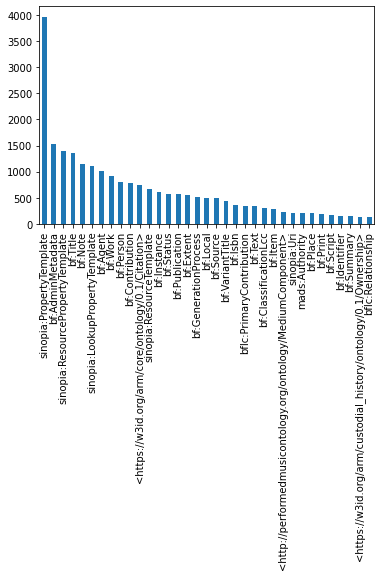

In [14]:
classes_df["class"].value_counts()[0:35].plot(kind="bar")